# Noob-friendly Titanic prediction by a noob

## Problem domain
The goal is to find out, what sorts of people were more likely to survive from the accident.
The result should contain each passenger and related prediction about the survival.

The survival prediction is a classification problem and the result will be presented in the following numerical form:
1 = survived
0 = deceased

## Data exploration
The first step is to get familiar with the data at hand. The goal is to questions like
- if the available data makes sense, what it describes
- what kind of features it has and what kind of impact (factor) they might have in regards of the problem
- what kind of distributions it might follow
- does it contain invalid values or some kind of outliers

#### Data structure

The data consists of training and test parts in csv format.
Let's load them and check the sizes.

In [12]:
# Library for data processing, CSV file I/O operations
import pandas as pd

# Data plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Math
import scipy

# Regex
import re

In [4]:
data_dir = './data/'
train_data_path = data_dir + 'train.csv'
test_data_path  = data_dir + 'test.csv'

In [5]:
train_data    = pd.read_csv(train_data_path)
test_data     = pd.read_csv(test_data_path)
combined_data = pd.concat([train_data, test_data])

In [6]:
def print_data_size(data):
    (rows, columns) = data.shape

    print(f'Row count: {rows}')
    print(f'Column count: {columns}\n')

In [7]:
print('Train data')
print_data_size(train_data)

print('Test data')
print_data_size(test_data)

print('Total')
print_data_size(combined_data)

Train data
Row count: 891
Column count: 12

Test data
Row count: 418
Column count: 11

Total
Row count: 1309
Column count: 12



There were 2224 people on board on the Titanic (https://en.wikipedia.org/wiki/Sinking_of_the_RMS_Titanic#Casualties_and_survivors) so not all the data is here. One valid approach would be to acquire more data by fetching the whole passenger dataset. The rest of the data is probably used to test the model submission so let's not use any extra data.

Test data is missing the correct classifications as expected, thus only 11 columns. We are aiming to predict surival results for this dataset.

#### Existing features

Next, let's explore what kind of values the dataset contains.

In [8]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Some of the column names are quite self-explanatory but a few need more details.

| Column        | Explanation                                                                       |
| ------------- | :-------------------------------------------------------------------------------- |
| Pclass        | Ticket class, 1 = 1st (upper), 2 = 2nd (middle), 3 = 3rd (bottom)                                            |
| SibSp         | Number of siblings / spouses aboard the Titanic                                   |
| Parch         | Number of parents / children aboard the Titanic                                   |
| Embarked      | Port where the passenger embarked, C = Cherbourd, Q = Queenstown, S = Southampton |

#### Data types

In [9]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


It seems the data contains both numerical and categorical data. Some rows also have missing values since there's non-null counts differing from 891 (the total row count in training set).

#### Null values

In [10]:
train_null = (train_data.isnull().sum() / len(train_data)) * 100
train_null = train_na.drop(train_na[train_na == 0].index).sort_values(ascending=False)
pd.DataFrame({'Null value ratio %' :train_na}).head()

NameError: name 'train_na' is not defined

### Visualisation analysis

In [ ]:
train_data.describe()

In [ ]:
train_data.describe(include=['O'])

In [ ]:
classification_categories = pd.DataFrame(train_data.Survived)
classification_categories = train_data.Survived.value_counts()

ax = classification_categories.plot.bar()
ax.set_xticklabels(('Deceased', 'Survived'), rotation=0)

for p in ax.patches:
    ax.annotate(str(p.get_height()), xy=(p.get_x() + p.get_width() / 2, p.get_height() / 2), ha='center', va='center', color='white')

There are a bit less than twice as much deceased passengers than survived.
This disproportionate ratio of observations in the categories might be a problem because the imbalance of the classes render the standard accuracy metrics useless.

Let's say there's a data set of 1000 observations. 990 observations are classified as deceased and 10 as survived.
We could just create a model which always predicts observations to be a deceased one and get insane accuracy.
Standard metric would give us 99% accuracy on our model just because the data set is heavily disproportionate.

In [ ]:
def survival_visualization(feature, axis):
    pd.crosstab(index=feature, columns=train_data.Survived).plot.bar(ax=axis, rot=0)

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15,4))
survival_visualization(train_data.Pclass, axes[0])
survival_visualization(train_data.Embarked, axes[1])
survival_visualization(train_data.Sex, axes[2])

In [ ]:
train_data['Cabin'] = pd.Series([i[0] if not pd.isnull(i) else 'U' for i in train_data['Cabin'] ])

In [ ]:
graph = sns.catplot(x='Cabin', y='Survived', data=train_data, kind="bar", height = 5,
                    palette = 'muted', order=['A','B','C','D','E','F','G','T','U'])
graph.set_ylabels("Survival probability")

In [ ]:
def mean_survival(feature):
    return train_data[[feature, 'Survived']].groupby([feature]).mean().sort_values(by='Survived', ascending=False)

In [ ]:
mean_survival('Pclass')

In [ ]:
mean_survival('Sex')

In [ ]:
mean_survival('SibSp')

In [ ]:
mean_survival('Embarked')

In [ ]:
mean_survival('Parch')

In [ ]:
train_data[['Survived','Age','Fare','Pclass','Sex']].groupby(['Pclass','Sex']).mean()

It seems
- First class (Pclass = 1) had a higher chance to survive
- Also sex had a correlation with survival, females were more likely to survive
- People with fewer siblings/spouses and parent/children along were more likely to survive
    - In other words, smaller families were more likely to survive
- At this point, it doesn't make sense that embark would matter, but let's not make final assumptions
    - There could be a correlation with something else

In [ ]:
grid = sns.FacetGrid(train_data, col='Survived')
grid.map(plt.hist, 'Age', bins=20)

In [ ]:
grid = sns.FacetGrid(train_data, col='Survived', row='Pclass')
grid.map(plt.hist, 'Age', bins=10)

- Children were more likely to survive
- Pclass = 3 had most passengers but most of them did not survive

#### Names

It could be easily concluded that name would not matter in regards of survival. Although name is sometimes a factor that assigns person's rank in society. Dataset contains names with titles and titles may mean higher status in society. People with higher social rank might easily get on life boats over regular person.

In [15]:
train_data['Name'].tail()

886                       Montvila, Rev. Juozas
887                Graham, Miss. Margaret Edith
888    Johnston, Miss. Catherine Helen "Carrie"
889                       Behr, Mr. Karl Howell
890                         Dooley, Mr. Patrick
Name: Name, dtype: object

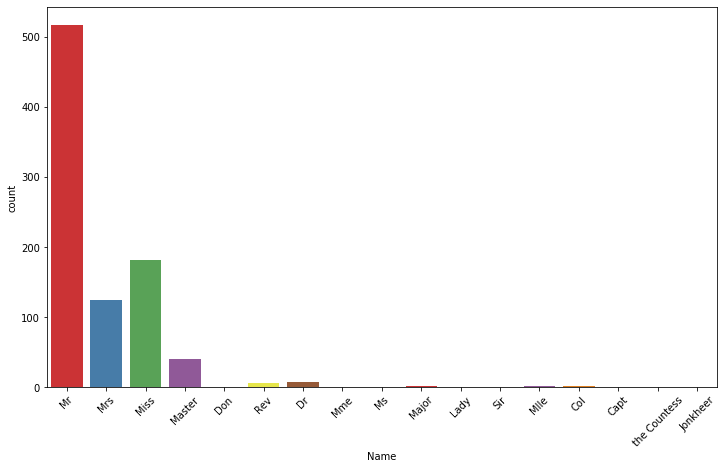

In [30]:
plt.figure(figsize=(12,7))

titles = train_data['Name'].map(lambda x: re.compile(", (.*?)\.").findall(x)[0])
chart = sns.countplot(x=titles, data=train_data, palette='Set1')
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)

plt.show()

In [36]:
titles.value_counts()

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Major             2
Mlle              2
Col               2
Capt              1
the Countess      1
Don               1
Sir               1
Jonkheer          1
Mme               1
Ms                1
Lady              1
Name: Name, dtype: int64

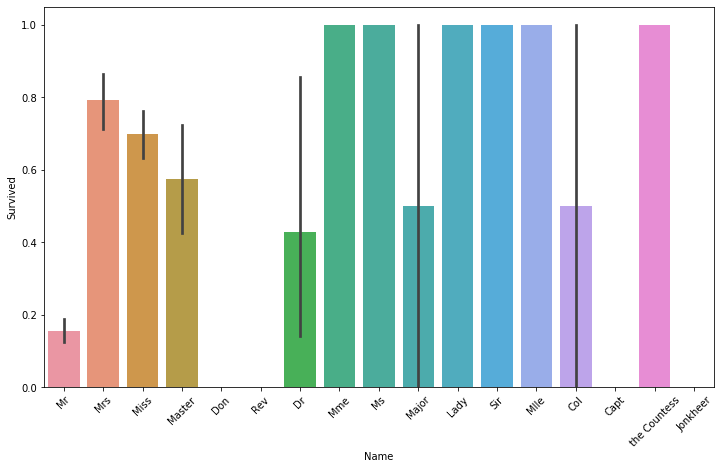

In [33]:
plt.figure(figsize=(12,7))
chart = sns.barplot(x=titles, y='Survived', data=train_data)
chart.set_xticklabels(chart.get_xticklabels(), rotation=45)
plt.show()

The chart supports our hypothesis about females probably surviving more likely than males.
Female titles all have high survival probability.

Also Master and Sir have high probabilities. There's only few people with these titles so very strong conclusions should not be drawn.

### Conclusions

The most important factors in regards of survival are seemingly sex and ticket class (Pclass). Also age and family size (parch + sibsp) have noticeable impact. Since almost 20% of the observations is missing age value and age being one of the major factors, the missing values should be handled in some way.

Most of the cabin values were missing so it's tempting to just drop this feature. Although cabin feature might be also critical considering survival. For example, the cabin might be located near the exits of the corridors which in turn might improve the probability of survival. It's reasonable to explore possibilities to impute this data, it may be possible to derive this informations from tickets.

People with (some) titles tend to have high survival probability so title might be a factor of survival. Let's include it as feature when building the model.

## Data cleaning and preparation
- is relevant data missing, how to compensate
- can some data be removed or simplified
- imputation
- scaling
- standardization
- augmentation
- no duplicates

In [ ]:
# Drop passenger id column since it doesn't really hold any relevant information, it's just an identifier
features = train_data.drop('PassengerId', axis='columns')

## Feature engineering

## Algorithm selection
- Regularization
- Ensembles

## Model training

## Evaluation